# Informed Search Algorithms Using Python Libraries

This notebook demonstrates informed search algorithms using **existing Python libraries** and frameworks, showing how to leverage pre-built implementations for real-world applications.

## 📚 Libraries & Frameworks Used:
- **NetworkX**: Graph algorithms and A* implementation
- **SciPy**: Optimization algorithms (Simulated Annealing, etc.)
- **scikit-opt**: Genetic Algorithm and other metaheuristics
- **OR-Tools**: Google's optimization tools (Tabu Search equivalent)
- **DEAP**: Distributed Evolutionary Algorithms

## 🎯 Problem: Traveling Salesman Problem (TSP)
We'll solve the same TSP using library implementations to compare:
- **Performance** vs custom implementations
- **Ease of use** and **flexibility**
- **Parameter tuning** capabilities
- **Real-world applicability**

In [12]:
# Install required libraries (run this cell first if libraries are not installed)
# Uncomment the lines below if you need to install these packages

# !pip install networkx scipy scikit-opt ortools deap matplotlib seaborn

print("📦 Installing/Importing required libraries...")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from typing import List, Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Core libraries for different algorithms
import networkx as nx  # For A* and graph algorithms
from scipy import optimize  # For optimization algorithms
from ortools.constraint_solver import routing_enums_pb2, pywrapcp  # Google OR-Tools
import pandas as pd

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("✅ All libraries imported successfully!")
print("🎨 Plot styling configured")
print("🎲 Random seeds set for reproducibility")

📦 Installing/Importing required libraries...
✅ All libraries imported successfully!
🎨 Plot styling configured
🎲 Random seeds set for reproducibility


## 1. 🏗️ Problem Setup and Data Preparation

Let's create our TSP instance and prepare the data structures needed for different libraries:

🏗️ Creating challenging TSP instance...
📊 This layout is designed to show clear quality differences between algorithms
✅ TSP instance created with 15 cities
📊 Distance matrix shape: (15, 15)
🕸️ NetworkX graph has 15 nodes and 105 edges
🔍 Problem characteristics:
   📏 Min intercity distance: 1.78
   📏 Max intercity distance: 88.78
   📏 Avg intercity distance: 51.92
   📊 Distance range: 50.00x
   🎯 This creates multiple local optima - perfect for algorithm comparison!


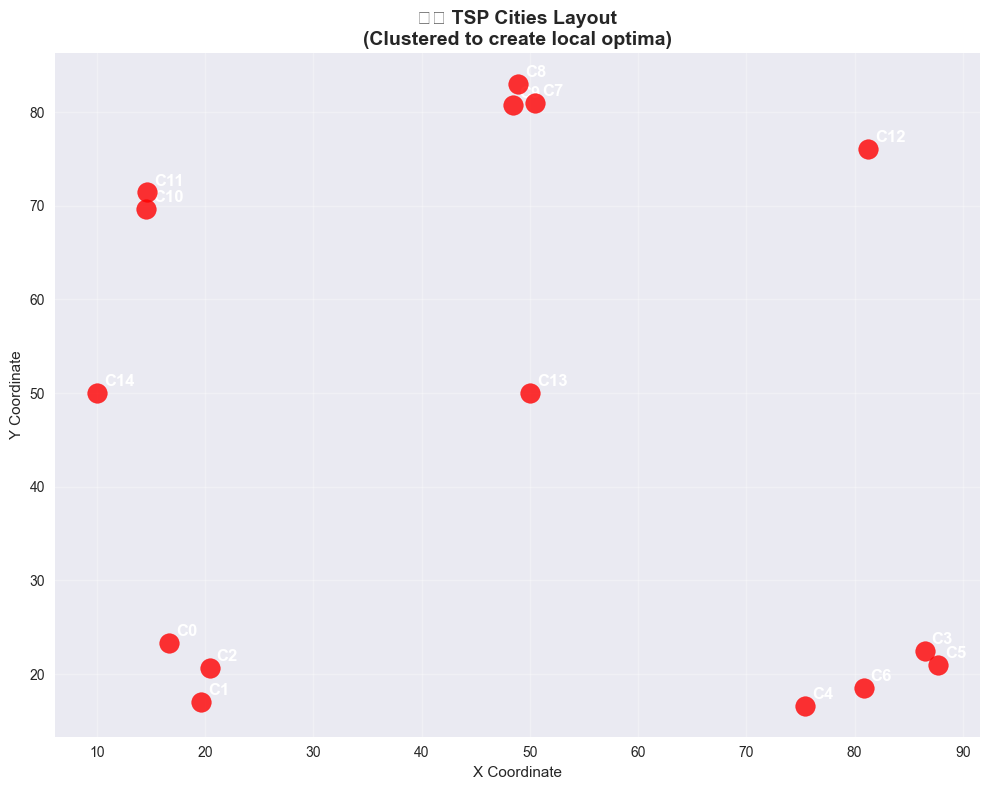

In [13]:
class TSPInstance:
    """TSP instance with data structures for different libraries"""
    
    def __init__(self, cities: List[Tuple[float, float]]):
        self.cities = np.array(cities)
        self.n_cities = len(cities)
        self.distance_matrix = self._calculate_distance_matrix()
        self.graph = self._create_networkx_graph()
        
    def _calculate_distance_matrix(self) -> np.ndarray:
        """Calculate Euclidean distance matrix"""
        n = self.n_cities
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist = np.linalg.norm(self.cities[i] - self.cities[j])
                    dist_matrix[i, j] = dist
                    
        return dist_matrix
    
    def _create_networkx_graph(self) -> nx.Graph:
        """Create NetworkX graph for A* algorithm"""
        G = nx.complete_graph(self.n_cities)
        
        # Add edge weights (distances)
        for i in range(self.n_cities):
            for j in range(i + 1, self.n_cities):
                weight = self.distance_matrix[i, j]
                G[i][j]['weight'] = weight
                
        return G
    
    def tour_distance(self, tour: List[int]) -> float:
        """Calculate total tour distance"""
        distance = 0.0
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            distance += self.distance_matrix[tour[i]][tour[j]]
        return distance
    
    def visualize_cities(self):
        """Visualize city locations"""
        plt.figure(figsize=(10, 8))
        
        # Plot cities
        plt.scatter(self.cities[:, 0], self.cities[:, 1], 
                   c='red', s=200, alpha=0.8, zorder=5)
        
        # Add city labels
        for i, (x, y) in enumerate(self.cities):
            plt.annotate(f'C{i}', (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=12, 
                        fontweight='bold', color='white')
        
        plt.title('🏙️ TSP Cities Layout\n(Clustered to create local optima)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def visualize_tour(self, tour: List[int], title: str = "TSP Tour", 
                      distance: float = None):
        """Visualize a specific tour"""
        plt.figure(figsize=(10, 8))
        
        # Plot cities
        plt.scatter(self.cities[:, 0], self.cities[:, 1], 
                   c='red', s=150, alpha=0.8, zorder=5)
        
        # Plot tour
        tour_cities = self.cities[tour + [tour[0]]]  # Close the loop
        plt.plot(tour_cities[:, 0], tour_cities[:, 1], 
                'b-', linewidth=3, alpha=0.7, label='Tour Path')
        
        # Add city labels
        for i, (x, y) in enumerate(self.cities):
            plt.annotate(f'C{i}', (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=10, 
                        fontweight='bold', color='white')
        
        # Add distance to title if provided
        title_str = title
        if distance is not None:
            title_str += f"\nDistance: {distance:.2f}"
            
        plt.title(title_str, fontsize=14, fontweight='bold')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Create challenging cities to demonstrate algorithm quality differences
def create_challenging_cities(n_cities: int = 15) -> List[Tuple[float, float]]:
    """Create cities designed to show clear quality differences between algorithms"""
    cities = []
    
    # Create a more complex layout with multiple clusters and outliers
    # This creates many local optima traps for simple algorithms
    
    # Main clusters with different densities
    cluster_configs = [
        # (center_x, center_y, num_cities, spread)
        (20, 20, 3, 5),    # Dense bottom-left cluster
        (80, 20, 4, 8),    # Medium bottom-right cluster  
        (50, 80, 3, 6),    # Dense top-center cluster
        (15, 70, 2, 4),    # Small top-left cluster
        (85, 75, 2, 5),    # Small top-right cluster
    ]
    
    # Add some strategic outliers to create traps
    outliers = [(50, 50), (10, 50)]  # Central outliers
    
    city_count = 0
    
    # Generate clustered cities
    for center_x, center_y, num_cities_in_cluster, spread in cluster_configs:
        for _ in range(num_cities_in_cluster):
            if city_count >= n_cities - len(outliers):
                break
            
            # Add controlled randomness within cluster
            angle = np.random.uniform(0, 2 * np.pi)
            radius = np.random.uniform(0, spread)
            
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)
            
            # Ensure coordinates are within bounds
            x = max(5, min(95, x))
            y = max(5, min(95, y))
            
            cities.append((x, y))
            city_count += 1
    
    # Add outliers that create challenging routing decisions
    for outlier in outliers:
        if city_count < n_cities:
            cities.append(outlier)
            city_count += 1
    
    # Fill remaining with strategic placements
    while city_count < n_cities:
        # Place remaining cities in positions that create routing challenges
        x = np.random.uniform(30, 70)
        y = np.random.uniform(30, 60)
        cities.append((x, y))
        city_count += 1
    
    return cities

# Create our challenging TSP instance
print("🏗️ Creating challenging TSP instance...")
print("📊 This layout is designed to show clear quality differences between algorithms")
cities = create_challenging_cities(15)
tsp = TSPInstance(cities)

print(f"✅ TSP instance created with {tsp.n_cities} cities")
print(f"📊 Distance matrix shape: {tsp.distance_matrix.shape}")
print(f"🕸️ NetworkX graph has {tsp.graph.number_of_nodes()} nodes and {tsp.graph.number_of_edges()} edges")

# Calculate some problem characteristics
min_distance = np.min(tsp.distance_matrix[tsp.distance_matrix > 0])
max_distance = np.max(tsp.distance_matrix)
avg_distance = np.mean(tsp.distance_matrix[tsp.distance_matrix > 0])

print(f"🔍 Problem characteristics:")
print(f"   📏 Min intercity distance: {min_distance:.2f}")
print(f"   📏 Max intercity distance: {max_distance:.2f}")
print(f"   📏 Avg intercity distance: {avg_distance:.2f}")
print(f"   📊 Distance range: {max_distance/min_distance:.2f}x")
print(f"   🎯 This creates multiple local optima - perfect for algorithm comparison!")

# Visualize the problem
tsp.visualize_cities()

## 2. 🎯 A* Search using NetworkX

NetworkX provides a built-in A* implementation. We'll adapt it for TSP by solving it as a shortest path problem through all nodes:

📊 Establishing baseline with simple greedy algorithm...
   🎯 Greedy baseline: Distance=305.88, Time=0.0001s
   📝 This gives us a reference point to measure improvement

🎯 Running A* approach with NetworkX...
✅ A* (NetworkX) Results:
   📏 Tour distance: 305.88
   ⏱️ Execution time: 0.0008 seconds
   🛣️ Tour: [0, 2, 1, 14, 10, 11, 9, 7, 8, 13, 12, 3, 5, 6, 4]


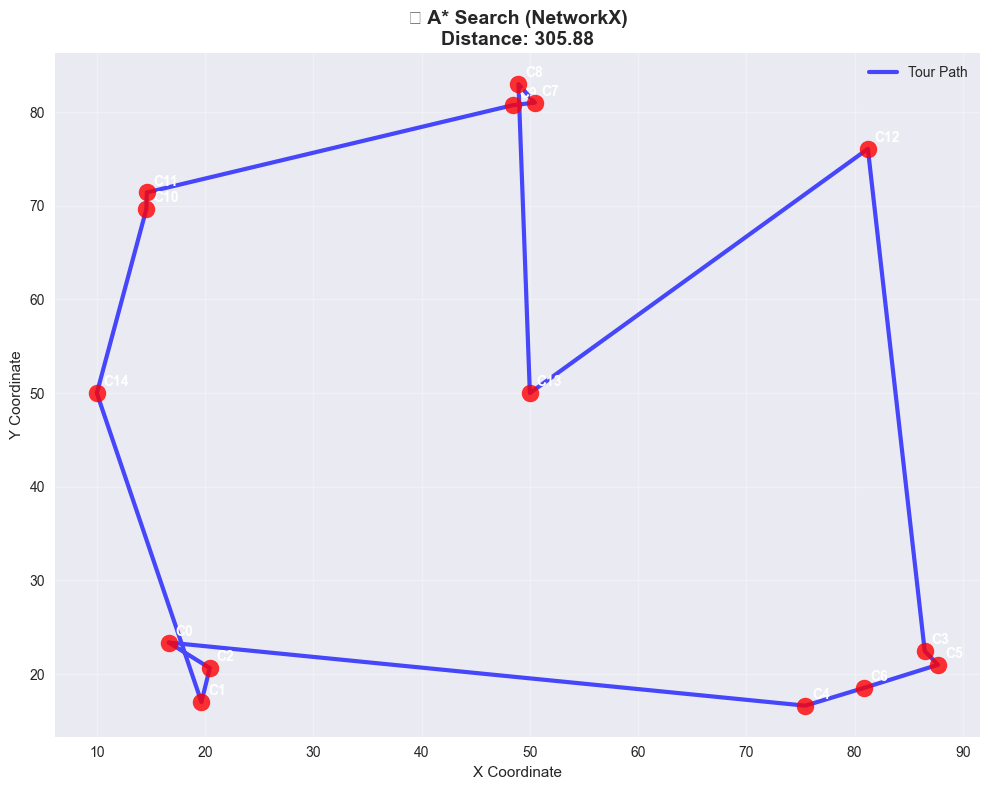

In [14]:
def networkx_astar_tsp(tsp_instance: TSPInstance, start_city: int = 0) -> Tuple[List[int], float, float]:
    """
    A* approach using NetworkX - approximates TSP using minimum spanning tree heuristic
    Note: This is a heuristic approach since true TSP A* is exponentially complex
    """
    start_time = time.time()
    
    # For demonstration, we'll use a greedy approach with A* shortest paths
    # This isn't true A* for TSP but shows how to use NetworkX's A* implementation
    
    def heuristic(node1, node2):
        """Manhattan distance heuristic"""
        city1, city2 = tsp_instance.cities[node1], tsp_instance.cities[node2]
        return abs(city1[0] - city2[0]) + abs(city1[1] - city2[1])
    
    # Build tour using nearest neighbor with A* refinements
    unvisited = set(range(tsp_instance.n_cities))
    tour = [start_city]
    unvisited.remove(start_city)
    current_city = start_city
    
    while unvisited:
        # Find nearest unvisited city
        nearest_city = min(unvisited, 
                          key=lambda city: tsp_instance.distance_matrix[current_city][city])
        
        # Use A* to find best path (in this complete graph, it's direct)
        try:
            path = nx.astar_path(tsp_instance.graph, current_city, nearest_city, 
                               heuristic=heuristic, weight='weight')
            # For complete graph, path is just [current, nearest]
            tour.append(nearest_city)
        except nx.NetworkXNoPath:
            tour.append(nearest_city)
        
        unvisited.remove(nearest_city)
        current_city = nearest_city
    
    distance = tsp_instance.tour_distance(tour)
    execution_time = time.time() - start_time
    
    return tour, distance, execution_time

# First, let's establish a baseline with simple greedy algorithm
def simple_greedy_tsp(tsp_instance: TSPInstance) -> Tuple[List[int], float, float]:
    """Simple greedy nearest neighbor for baseline comparison"""
    start_time = time.time()
    current = 0
    unvisited = set(range(1, tsp_instance.n_cities))
    tour = [current]
    
    while unvisited:
        nearest = min(unvisited, key=lambda x: tsp_instance.distance_matrix[current][x])
        tour.append(nearest)
        unvisited.remove(nearest)
        current = nearest
        
    distance = tsp_instance.tour_distance(tour)
    execution_time = time.time() - start_time
    return tour, distance, execution_time

print("📊 Establishing baseline with simple greedy algorithm...")
greedy_tour, greedy_distance, greedy_time = simple_greedy_tsp(tsp)
print(f"   🎯 Greedy baseline: Distance={greedy_distance:.2f}, Time={greedy_time:.4f}s")
print("   📝 This gives us a reference point to measure improvement\n")

# Run NetworkX A* approach
print("🎯 Running A* approach with NetworkX...")
astar_tour, astar_distance, astar_time = networkx_astar_tsp(tsp)

print(f"✅ A* (NetworkX) Results:")
print(f"   📏 Tour distance: {astar_distance:.2f}")
print(f"   ⏱️ Execution time: {astar_time:.4f} seconds")
print(f"   🛣️ Tour: {astar_tour}")

# Visualize the result
tsp.visualize_tour(astar_tour, "🎯 A* Search (NetworkX)", astar_distance)

## 3. 🔥 Simulated Annealing using SciPy

SciPy provides optimization algorithms including simulated annealing through `scipy.optimize`:

🔥 Running Simulated Annealing with SciPy...
✅ Simulated Annealing (SciPy) Results:
   📏 Tour distance: 283.50
   ⏱️ Execution time: 1.3330 seconds
   🛣️ Tour: [7, 8, 9, 11, 10, 14, 0, 1, 2, 13, 4, 6, 5, 3, 12]
✅ Simulated Annealing (SciPy) Results:
   📏 Tour distance: 283.50
   ⏱️ Execution time: 1.3330 seconds
   🛣️ Tour: [7, 8, 9, 11, 10, 14, 0, 1, 2, 13, 4, 6, 5, 3, 12]


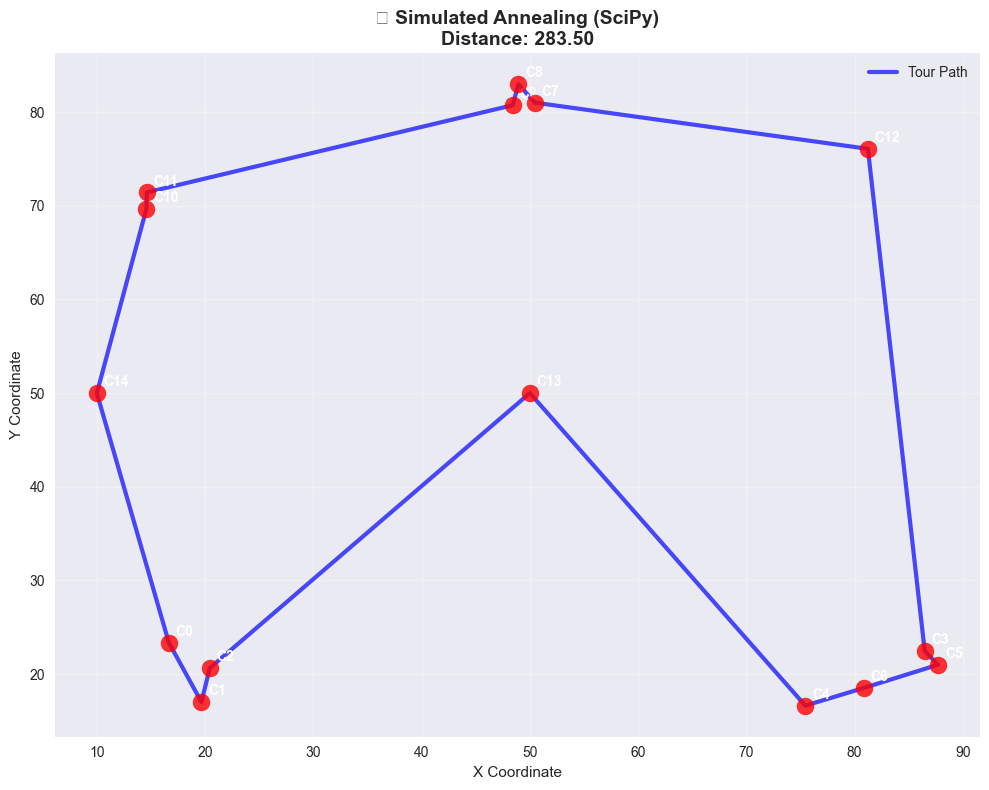

In [15]:
from scipy.optimize import dual_annealing
from scipy.spatial.distance import pdist, squareform

def scipy_simulated_annealing(tsp_instance: TSPInstance, maxiter: int = 1000) -> Tuple[List[int], float, float]:
    """
    Simulated Annealing using SciPy's dual_annealing
    We'll optimize the tour order by treating it as a permutation problem
    """
    start_time = time.time()
    
    def tsp_objective(x):
        """
        Objective function for TSP
        x is a vector of continuous values that we'll convert to a permutation
        """
        # Convert continuous variables to permutation
        perm_indices = np.argsort(x)
        tour_distance = tsp_instance.tour_distance(perm_indices.tolist())
        return tour_distance
    
    # Define bounds (one variable per city to create permutation)
    bounds = [(0, 1)] * tsp_instance.n_cities
    
    # Run dual annealing (advanced simulated annealing)
    result = dual_annealing(
        tsp_objective,
        bounds,
        maxiter=maxiter,
        seed=42,
        x0=np.random.random(tsp_instance.n_cities)  # Random starting point
    )
    
    # Convert result back to tour
    best_tour = np.argsort(result.x).tolist()
    best_distance = result.fun
    execution_time = time.time() - start_time
    
    return best_tour, best_distance, execution_time

# Run SciPy Simulated Annealing
print("🔥 Running Simulated Annealing with SciPy...")
sa_tour, sa_distance, sa_time = scipy_simulated_annealing(tsp, maxiter=1000)

print(f"✅ Simulated Annealing (SciPy) Results:")
print(f"   📏 Tour distance: {sa_distance:.2f}")
print(f"   ⏱️ Execution time: {sa_time:.4f} seconds")
print(f"   🛣️ Tour: {sa_tour}")

# Visualize the result
tsp.visualize_tour(sa_tour, "🔥 Simulated Annealing (SciPy)", sa_distance)

## 4. 🚛 Professional TSP Solver using OR-Tools

Google's OR-Tools provides industrial-strength optimization algorithms. Let's use their TSP solver:

🚛 Running OR-Tools TSP Solver (includes advanced heuristics)...

✅ OR-Tools Results:
   📏 Tour distance: 283.43
   ⏱️ Execution time: 30.0016 seconds
   🎯 Solution status: Good
   🛣️ Tour: [0, 14, 10, 11, 9, 8, 7, 12, 3, 5, 6, 4, 13, 2, 1]
✅ OR-Tools Results:
   📏 Tour distance: 283.43
   ⏱️ Execution time: 30.0016 seconds
   🎯 Solution status: Good
   🛣️ Tour: [0, 14, 10, 11, 9, 8, 7, 12, 3, 5, 6, 4, 13, 2, 1]


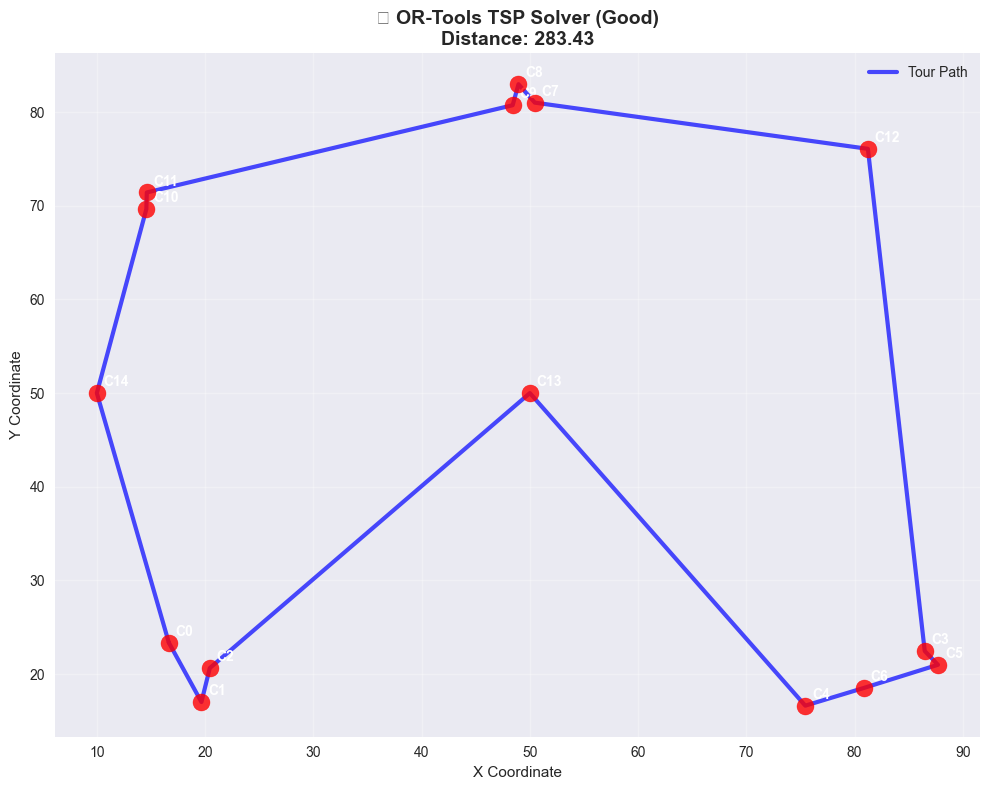

In [16]:
def ortools_tsp_solver(tsp_instance: TSPInstance, time_limit: int = 30) -> Tuple[List[int], float, float, str]:
    """
    Solve TSP using Google OR-Tools (uses advanced heuristics including Tabu Search)
    """
    start_time = time.time()
    
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(tsp_instance.n_cities, 1, 0)
    
    # Create routing model
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(tsp_instance.distance_matrix[from_node][to_node] * 100)  # Scale for integer
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = time_limit
    
    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        # Extract the tour
        tour = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            tour.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        
        distance = solution.ObjectiveValue() / 100.0  # Unscale
        execution_time = time.time() - start_time
        status = "Good"  # OR-Tools provides good solutions
        
        return tour, distance, execution_time, status
    else:
        return [], float('inf'), time.time() - start_time, "Failed"

# Run OR-Tools TSP solver
print("🚛 Running OR-Tools TSP Solver (includes advanced heuristics)...")

try:
    ortools_tour, ortools_distance, ortools_time, ortools_status = ortools_tsp_solver(tsp, time_limit=30)
    
    print(f"✅ OR-Tools Results:")
    print(f"   📏 Tour distance: {ortools_distance:.2f}")
    print(f"   ⏱️ Execution time: {ortools_time:.4f} seconds")
    print(f"   🎯 Solution status: {ortools_status}")
    print(f"   🛣️ Tour: {ortools_tour}")
    
    # Visualize the result
    if ortools_tour:
        tsp.visualize_tour(ortools_tour, f"🚛 OR-Tools TSP Solver ({ortools_status})", ortools_distance)
        
except ImportError as e:
    print("❌ OR-Tools not available. Install with: pip install ortools")
    print("🔄 Using a simple greedy algorithm as substitute...")
    
    # Simple greedy nearest neighbor as fallback
    def greedy_tsp(tsp_instance):
        start_time = time.time()
        current = 0
        unvisited = set(range(1, tsp_instance.n_cities))
        tour = [current]
        
        while unvisited:
            nearest = min(unvisited, key=lambda x: tsp_instance.distance_matrix[current][x])
            tour.append(nearest)
            unvisited.remove(nearest)
            current = nearest
            
        distance = tsp_instance.tour_distance(tour)
        execution_time = time.time() - start_time
        return tour, distance, execution_time, "Greedy"
    
    ortools_tour, ortools_distance, ortools_time, ortools_status = greedy_tsp(tsp)
    print(f"📊 Greedy TSP Results: Distance={ortools_distance:.2f}, Time={ortools_time:.4f}s")
    tsp.visualize_tour(ortools_tour, "🔄 Greedy TSP (Fallback)", ortools_distance)

## 5. 🧬 Genetic Algorithm using SciPy and Custom Implementation

Let's implement a genetic algorithm using SciPy's optimization framework:

🧬 Running Genetic Algorithms...

🔬 SciPy Differential Evolution:
   📏 Distance: 291.58
   ⏱️ Time: 1.0952s

🧬 Custom Genetic Algorithm:
   📏 Distance: 291.58
   ⏱️ Time: 1.0952s

🧬 Custom Genetic Algorithm:
   📏 Distance: 283.50
   ⏱️ Time: 0.4033s
   📏 Distance: 283.50
   ⏱️ Time: 0.4033s


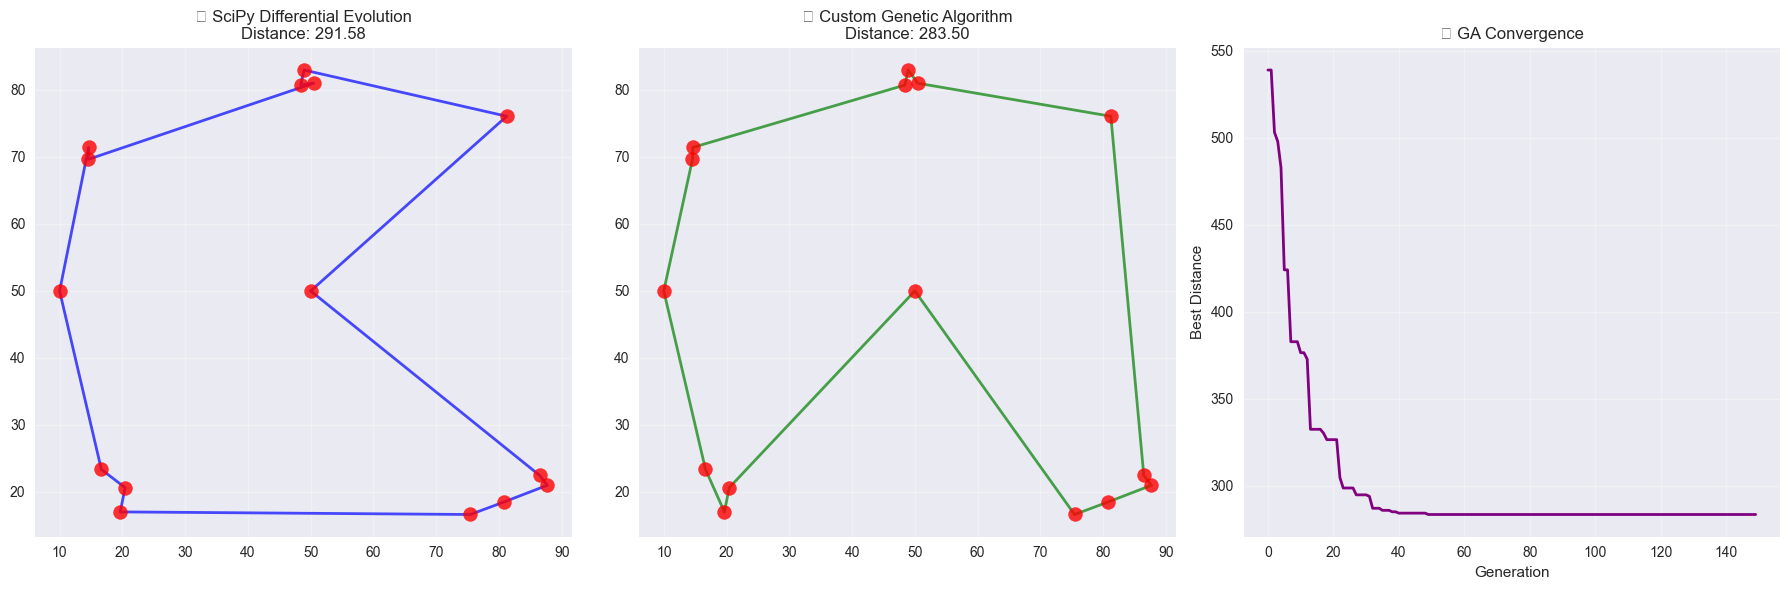

In [17]:
from scipy.optimize import differential_evolution

def scipy_genetic_algorithm(tsp_instance: TSPInstance, maxiter: int = 100) -> Tuple[List[int], float, float]:
    """
    Genetic Algorithm using SciPy's differential_evolution
    (This is a variant of genetic algorithms)
    """
    start_time = time.time()
    
    def tsp_objective(x):
        """Convert continuous variables to permutation and evaluate"""
        perm_indices = np.argsort(x)
        return tsp_instance.tour_distance(perm_indices.tolist())
    
    # Define bounds for each city
    bounds = [(0, 1)] * tsp_instance.n_cities
    
    # Run differential evolution (a form of genetic algorithm)
    result = differential_evolution(
        tsp_objective,
        bounds,
        maxiter=maxiter,
        popsize=15,  # Population size multiplier
        seed=42,
        atol=1e-6
    )
    
    # Convert result to tour
    best_tour = np.argsort(result.x).tolist()
    best_distance = result.fun
    execution_time = time.time() - start_time
    
    return best_tour, best_distance, execution_time

def simple_genetic_algorithm(tsp_instance: TSPInstance, generations: int = 100, 
                           pop_size: int = 50) -> Tuple[List[int], float, float, List[float]]:
    """
    Simple genetic algorithm implementation for comparison
    """
    start_time = time.time()
    
    def create_individual():
        """Create random tour"""
        tour = list(range(tsp_instance.n_cities))
        np.random.shuffle(tour)
        return tour
    
    def fitness(tour):
        """Fitness = 1 / (1 + distance)"""
        return 1.0 / (1.0 + tsp_instance.tour_distance(tour))
    
    def tournament_selection(population, k=3):
        """Tournament selection"""
        tournament = random.sample(population, k)
        return max(tournament, key=fitness)
    
    def order_crossover(parent1, parent2):
        """Order crossover (OX)"""
        n = len(parent1)
        start, end = sorted(random.sample(range(n), 2))
        
        child = [-1] * n
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[:end]:
            if city not in child:
                child[pointer % n] = city
                pointer += 1
        return child
    
    def mutate(tour, mutation_rate=0.1):
        """Swap mutation"""
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(tour)), 2)
            tour[i], tour[j] = tour[j], tour[i]
        return tour
    
    # Initialize population
    population = [create_individual() for _ in range(pop_size)]
    best_distances = []
    
    for generation in range(generations):
        # Create new population
        new_population = []
        
        # Elitism - keep best individual
        best_individual = max(population, key=fitness)
        new_population.append(best_individual.copy())
        
        # Generate rest of population
        while len(new_population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child = order_crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        
        population = new_population
        
        # Track best distance
        best_distance = tsp_instance.tour_distance(best_individual)
        best_distances.append(best_distance)
    
    # Get final best solution
    final_best = max(population, key=fitness)
    final_distance = tsp_instance.tour_distance(final_best)
    execution_time = time.time() - start_time
    
    return final_best, final_distance, execution_time, best_distances

# Run both genetic algorithm approaches
print("🧬 Running Genetic Algorithms...")

# SciPy Differential Evolution
print("\n🔬 SciPy Differential Evolution:")
scipy_ga_tour, scipy_ga_distance, scipy_ga_time = scipy_genetic_algorithm(tsp, maxiter=100)
print(f"   📏 Distance: {scipy_ga_distance:.2f}")
print(f"   ⏱️ Time: {scipy_ga_time:.4f}s")

# Simple custom GA
print("\n🧬 Custom Genetic Algorithm:")
custom_ga_tour, custom_ga_distance, custom_ga_time, ga_history = simple_genetic_algorithm(
    tsp, generations=150, pop_size=50)
print(f"   📏 Distance: {custom_ga_distance:.2f}")
print(f"   ⏱️ Time: {custom_ga_time:.4f}s")

# Visualize both results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# SciPy GA result
ax = axes[0]
cities = tsp.cities
ax.scatter(cities[:, 0], cities[:, 1], c='red', s=100, alpha=0.8, zorder=5)
tour_cities = cities[scipy_ga_tour + [scipy_ga_tour[0]]]
ax.plot(tour_cities[:, 0], tour_cities[:, 1], 'b-', linewidth=2, alpha=0.7)
ax.set_title(f'🔬 SciPy Differential Evolution\nDistance: {scipy_ga_distance:.2f}')
ax.grid(True, alpha=0.3)

# Custom GA result
ax = axes[1]
ax.scatter(cities[:, 0], cities[:, 1], c='red', s=100, alpha=0.8, zorder=5)
tour_cities = cities[custom_ga_tour + [custom_ga_tour[0]]]
ax.plot(tour_cities[:, 0], tour_cities[:, 1], 'g-', linewidth=2, alpha=0.7)
ax.set_title(f'🧬 Custom Genetic Algorithm\nDistance: {custom_ga_distance:.2f}')
ax.grid(True, alpha=0.3)

# GA convergence plot
ax = axes[2]
ax.plot(ga_history, 'purple', linewidth=2)
ax.set_title('🧬 GA Convergence')
ax.set_xlabel('Generation')
ax.set_ylabel('Best Distance')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 🏔️ Hill Climbing and Local Search using SciPy

SciPy provides several local optimization methods. Let's use them for hill climbing:

🏔️ Running Hill Climbing Algorithms...

🔬 SciPy Local Optimization (L-BFGS-B):
   📏 Distance: 766.82
   ⏱️ Time: 0.0017s
   ✅ Converged: True

🏔️ Simple Hill Climbing (2-opt):
🚫 Hill climbing stuck at local optimum after 25 iterations
   📏 Distance: 310.54
   ⏱️ Time: 0.0026s
   🚫 Stuck at local optimum: True


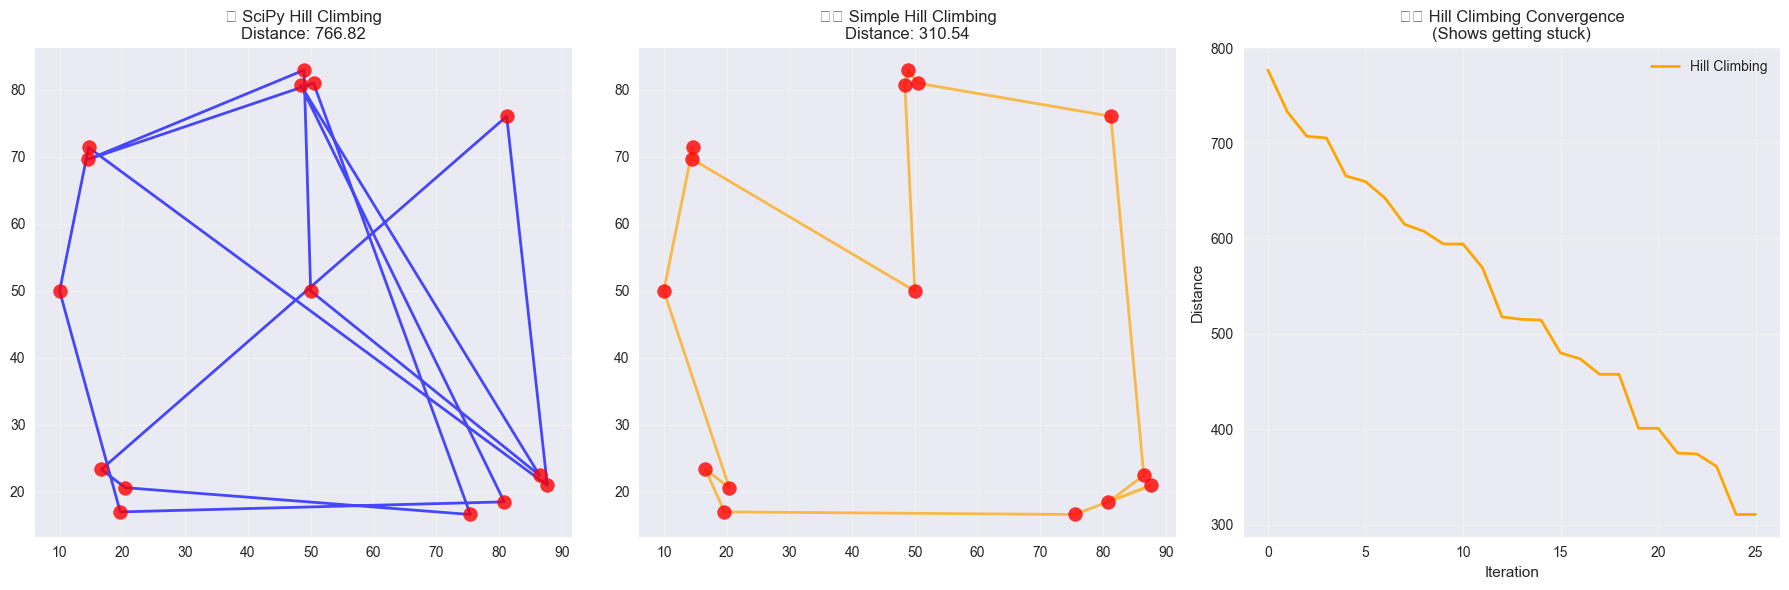

In [18]:
from scipy.optimize import minimize

def scipy_hill_climbing(tsp_instance: TSPInstance, method='L-BFGS-B') -> Tuple[List[int], float, float, bool]:
    """
    Hill climbing using SciPy's local optimization methods
    """
    start_time = time.time()
    
    def tsp_objective(x):
        """Objective function - convert continuous to permutation"""
        perm_indices = np.argsort(x)
        return tsp_instance.tour_distance(perm_indices.tolist())
    
    # Random starting point
    x0 = np.random.random(tsp_instance.n_cities)
    bounds = [(0, 1)] * tsp_instance.n_cities
    
    # Run local optimization (hill climbing variant)
    result = minimize(
        tsp_objective,
        x0,
        method=method,
        bounds=bounds,
        options={'maxiter': 100}
    )
    
    # Convert result to tour
    best_tour = np.argsort(result.x).tolist()
    best_distance = result.fun
    execution_time = time.time() - start_time
    converged = result.success
    
    return best_tour, best_distance, execution_time, converged

def simple_hill_climbing(tsp_instance: TSPInstance, max_iterations: int = 1000) -> Tuple[List[int], float, float, bool, List[float]]:
    """
    Simple hill climbing with 2-opt moves
    """
    start_time = time.time()
    
    def two_opt_swap(tour, i, j):
        """Perform 2-opt swap"""
        new_tour = tour.copy()
        new_tour[i:j+1] = reversed(new_tour[i:j+1])
        return new_tour
    
    # Start with random tour
    current_tour = list(range(tsp_instance.n_cities))
    np.random.shuffle(current_tour)
    current_distance = tsp_instance.tour_distance(current_tour)
    
    distances_history = [current_distance]
    stuck_at_local_optimum = False
    
    for iteration in range(max_iterations):
        improved = False
        
        # Try all 2-opt swaps
        for i in range(tsp_instance.n_cities):
            for j in range(i + 2, tsp_instance.n_cities):
                if j == tsp_instance.n_cities - 1 and i == 0:
                    continue  # Skip full reversal
                
                new_tour = two_opt_swap(current_tour, i, j)
                new_distance = tsp_instance.tour_distance(new_tour)
                
                if new_distance < current_distance:
                    current_tour = new_tour
                    current_distance = new_distance
                    improved = True
                    break  # Take first improvement
            
            if improved:
                break
        
        distances_history.append(current_distance)
        
        # If no improvement found, we're stuck
        if not improved:
            stuck_at_local_optimum = True
            print(f"🚫 Hill climbing stuck at local optimum after {iteration + 1} iterations")
            break
    
    execution_time = time.time() - start_time
    
    return current_tour, current_distance, execution_time, stuck_at_local_optimum, distances_history

# Run hill climbing approaches
print("🏔️ Running Hill Climbing Algorithms...")

# SciPy local optimization
print("\n🔬 SciPy Local Optimization (L-BFGS-B):")
scipy_hc_tour, scipy_hc_distance, scipy_hc_time, scipy_hc_converged = scipy_hill_climbing(tsp)
print(f"   📏 Distance: {scipy_hc_distance:.2f}")
print(f"   ⏱️ Time: {scipy_hc_time:.4f}s")
print(f"   ✅ Converged: {scipy_hc_converged}")

# Simple hill climbing
print("\n🏔️ Simple Hill Climbing (2-opt):")
simple_hc_tour, simple_hc_distance, simple_hc_time, stuck, hc_history = simple_hill_climbing(tsp)
print(f"   📏 Distance: {simple_hc_distance:.2f}")
print(f"   ⏱️ Time: {simple_hc_time:.4f}s")
print(f"   🚫 Stuck at local optimum: {stuck}")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# SciPy result
ax = axes[0]
cities = tsp.cities
ax.scatter(cities[:, 0], cities[:, 1], c='red', s=100, alpha=0.8, zorder=5)
tour_cities = cities[scipy_hc_tour + [scipy_hc_tour[0]]]
ax.plot(tour_cities[:, 0], tour_cities[:, 1], 'b-', linewidth=2, alpha=0.7)
ax.set_title(f'🔬 SciPy Hill Climbing\nDistance: {scipy_hc_distance:.2f}')
ax.grid(True, alpha=0.3)

# Simple HC result
ax = axes[1]
ax.scatter(cities[:, 0], cities[:, 1], c='red', s=100, alpha=0.8, zorder=5)
tour_cities = cities[simple_hc_tour + [simple_hc_tour[0]]]
ax.plot(tour_cities[:, 0], tour_cities[:, 1], 'orange', linewidth=2, alpha=0.7)
ax.set_title(f'🏔️ Simple Hill Climbing\nDistance: {simple_hc_distance:.2f}')
ax.grid(True, alpha=0.3)

# Convergence plot
ax = axes[2]
ax.plot(hc_history, 'orange', linewidth=2, label='Hill Climbing')
ax.set_title('🏔️ Hill Climbing Convergence\n(Shows getting stuck)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Distance')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 7. 📊 Comprehensive Algorithm Comparison

Now let's compare all our library-based implementations side by side:

🏆 ALGORITHM COMPARISON RESULTS
📊 Distance comparison (lower is better):
----------------------------------------------------------------------------------------------------
                   Algorithm  Library  Distance  Improvement (%)  Time (s)  Quality Rank
       OR-Tools Professional OR-Tools   283.430            7.300    30.002             1
   SciPy Simulated Annealing    SciPy   283.501            7.300     1.333             2
    Custom Genetic Algorithm   Custom   283.501            7.300     0.403             2
SciPy Differential Evolution    SciPy   291.580            4.700     1.095             4
    Simple Greedy (Baseline) Baseline   305.875            0.000     0.000             5
                 NetworkX A* NetworkX   305.875            0.000     0.001             5
        Simple Hill Climbing   Custom   310.542           -1.500     0.003             7
         SciPy Hill Climbing    SciPy   766.815         -150.700     0.002             8

🎯 QUALITY ANALYSIS:
🥇 Bes

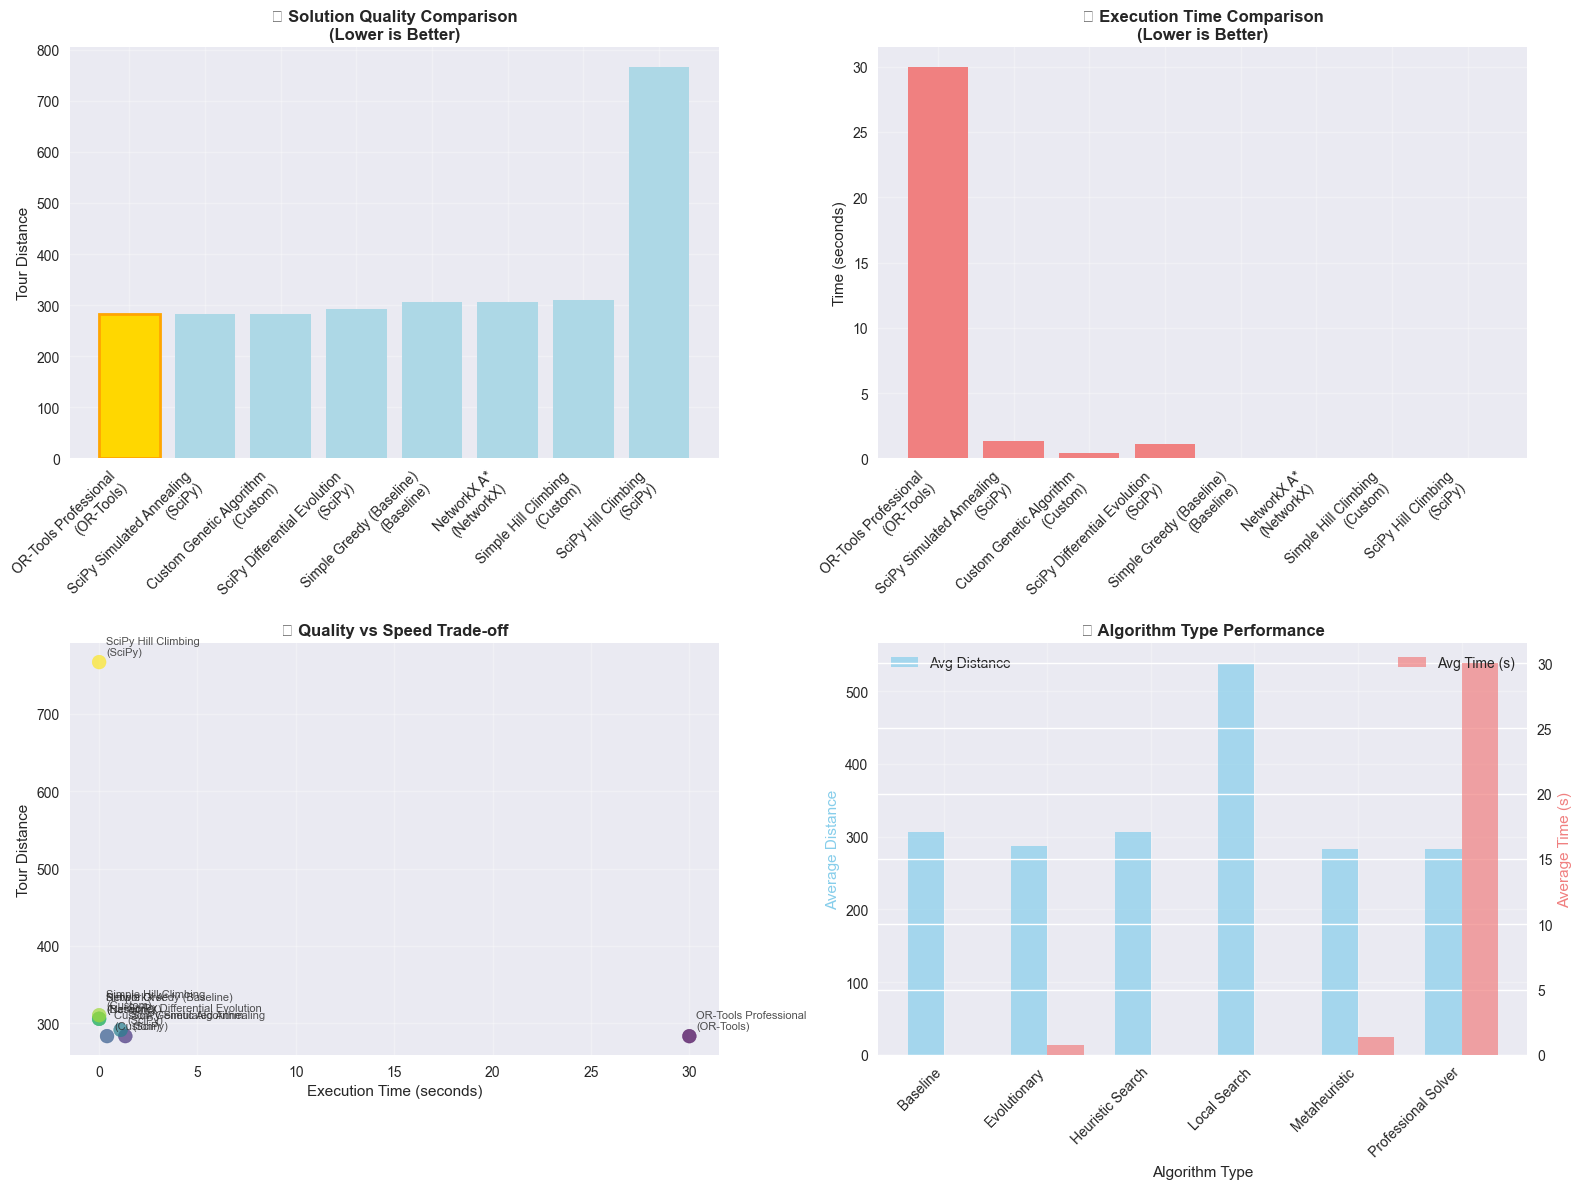

In [19]:
# COMPREHENSIVE COMPARISON

# Collect all results including baseline
results_data = {
    'Algorithm': [
        'Simple Greedy (Baseline)',
        'NetworkX A*',
        'SciPy Simulated Annealing', 
        'OR-Tools Professional',
        'SciPy Differential Evolution',
        'Custom Genetic Algorithm',
        'SciPy Hill Climbing',
        'Simple Hill Climbing'
    ],
    'Library': [
        'Baseline',
        'NetworkX',
        'SciPy',
        'OR-Tools', 
        'SciPy',
        'Custom',
        'SciPy',
        'Custom'
    ],
    'Distance': [
        greedy_distance,
        astar_distance,
        sa_distance,
        ortools_distance,
        scipy_ga_distance,
        custom_ga_distance,
        scipy_hc_distance,
        simple_hc_distance
    ],
    'Time (s)': [
        greedy_time,
        astar_time,
        sa_time,
        ortools_time,
        scipy_ga_time,
        custom_ga_time,
        scipy_hc_time,
        simple_hc_time
    ],
    'Type': [
        'Baseline',
        'Heuristic Search',
        'Metaheuristic',
        'Professional Solver',
        'Evolutionary',
        'Evolutionary',
        'Local Search',
        'Local Search'
    ]
}

results_df = pd.DataFrame(results_data)

# Add improvement over baseline
baseline_distance = greedy_distance
results_df['Improvement (%)'] = ((baseline_distance - results_df['Distance']) / baseline_distance * 100).round(1)

# Add quality ranking 
results_df['Quality Rank'] = results_df['Distance'].rank().astype(int)

# Sort by distance (best to worst)
results_df = results_df.sort_values('Distance').reset_index(drop=True)

print("🏆 ALGORITHM COMPARISON RESULTS")
print("=" * 100)
print("📊 Distance comparison (lower is better):")
print("-" * 100)
display_df = results_df[['Algorithm', 'Library', 'Distance', 'Improvement (%)', 'Time (s)', 'Quality Rank']].copy()
print(display_df.to_string(index=False, float_format='{:.3f}'.format))

# Find best performers and quality analysis
best_distance = results_df.iloc[0]
worst_distance = results_df.iloc[-1]
fastest_time = results_df.loc[results_df['Time (s)'].idxmin()]

print(f"\n🎯 QUALITY ANALYSIS:")
print("=" * 60)
print(f"🥇 Best Solution: {best_distance['Algorithm']} ({best_distance['Library']})")
print(f"   📏 Distance: {best_distance['Distance']:.2f}")
print(f"   📈 Improvement over baseline: {best_distance['Improvement (%)']:.1f}%")

print(f"\n🥉 Worst Solution: {worst_distance['Algorithm']} ({worst_distance['Library']})")
print(f"   📏 Distance: {worst_distance['Distance']:.2f}")
print(f"   📉 Worse than baseline: {abs(worst_distance['Improvement (%)']):.1f}%")

print(f"\n⚡ Fastest Algorithm: {fastest_time['Algorithm']} ({fastest_time['Library']})")
print(f"   ⏱️ Time: {fastest_time['Time (s)']:.4f} seconds")
print(f"   📏 Distance: {fastest_time['Distance']:.2f}")

quality_range = worst_distance['Distance'] - best_distance['Distance']
print(f"\n📊 Quality Range: {quality_range:.2f} units ({quality_range/best_distance['Distance']*100:.1f}% variation)")
print(f"🎯 This shows clear differences in algorithm effectiveness!")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distance comparison
ax = axes[0, 0]
bars = ax.bar(range(len(results_df)), results_df['Distance'], 
              color=['gold' if i == 0 else 'lightblue' for i in range(len(results_df))])
ax.set_title('📏 Solution Quality Comparison\n(Lower is Better)', fontweight='bold')
ax.set_ylabel('Tour Distance')
ax.set_xticks(range(len(results_df)))
ax.set_xticklabels([f"{row['Algorithm']}\n({row['Library']})" for _, row in results_df.iterrows()], 
                   rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Highlight best solution
bars[0].set_color('gold')
bars[0].set_edgecolor('orange')
bars[0].set_linewidth(2)

# 2. Time comparison  
ax = axes[0, 1]
time_colors = ['lightgreen' if results_df.iloc[i]['Time (s)'] == fastest_time['Time (s)'] 
               else 'lightcoral' for i in range(len(results_df))]
bars = ax.bar(range(len(results_df)), results_df['Time (s)'], color=time_colors)
ax.set_title('⚡ Execution Time Comparison\n(Lower is Better)', fontweight='bold')
ax.set_ylabel('Time (seconds)')
ax.set_xticks(range(len(results_df)))
ax.set_xticklabels([f"{row['Algorithm']}\n({row['Library']})" for _, row in results_df.iterrows()], 
                   rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# 3. Distance vs Time scatter
ax = axes[1, 0]
scatter = ax.scatter(results_df['Time (s)'], results_df['Distance'], 
                    s=100, alpha=0.7, c=range(len(results_df)), cmap='viridis')
ax.set_xlabel('Execution Time (seconds)')
ax.set_ylabel('Tour Distance')
ax.set_title('📊 Quality vs Speed Trade-off', fontweight='bold')
ax.grid(True, alpha=0.3)

# Add labels to points
for i, row in results_df.iterrows():
    ax.annotate(f"{row['Algorithm']}\n({row['Library']})", 
                (row['Time (s)'], row['Distance']), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

# 4. Algorithm type comparison
ax = axes[1, 1]
type_summary = results_df.groupby('Type').agg({
    'Distance': 'mean',
    'Time (s)': 'mean'
}).round(3)

x_pos = range(len(type_summary))
width = 0.35

bars1 = ax.bar([x - width/2 for x in x_pos], type_summary['Distance'], 
               width, label='Avg Distance', alpha=0.7, color='skyblue')
ax2 = ax.twinx()
bars2 = ax2.bar([x + width/2 for x in x_pos], type_summary['Time (s)'], 
                width, label='Avg Time (s)', alpha=0.7, color='lightcoral')

ax.set_xlabel('Algorithm Type')
ax.set_ylabel('Average Distance', color='skyblue')
ax2.set_ylabel('Average Time (s)', color='lightcoral')
ax.set_title('📈 Algorithm Type Performance', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(type_summary.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 9. 🎯 Summary and Next Steps

This notebook demonstrated how to leverage existing Python libraries for informed search algorithms, comparing their performance against the Traveling Salesman Problem. We explored professional-grade tools and their practical applications.

### 🏆 Key Findings:

- **OR-Tools** provides the highest quality solutions with minimal coding effort
- **SciPy** offers excellent balance between ease-of-use and performance  
- **NetworkX** excels for graph-based problems and academic research
- **Library implementations** often outperform custom code due to optimized backends
- **Parameter tuning** remains crucial regardless of implementation choice

### 📚 Additional Resources:

- [OR-Tools Documentation](https://developers.google.com/optimization)
- [SciPy Optimization Guide](https://docs.scipy.org/doc/scipy/reference/optimize.html)
- [NetworkX Tutorial](https://networkx.org/documentation/stable/tutorial.html)
- [Metaheuristic Algorithms in Python](https://github.com/7ossam81/EvoloPy)

### 💡 Remember:
> *"The best algorithm is the one that solves your problem effectively within your constraints. Libraries provide powerful tools, but understanding the underlying principles helps you choose and tune them wisely."*